In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DiadFit as pf


In [3]:
#!pip install --upgrade DiadFit

In [4]:
df_combo=pd.read_excel('Raman_SEM_Merged.xlsx')
df_combo=df_combo.loc[df_combo['Fo']>0].reset_index(drop=True)
len(df_combo)

149

## Lets load over the XH2O correction
- This is from DeVitre and Wieser (2024) GPL

In [5]:
import pickle
# This is the lowest XH2O
with open('Pf.pkl', 'rb') as f:
    Pf_low = pickle.load(f)

# This is the median XH2O
with open('Pf3.pkl', 'rb') as f:
    Pf_max = pickle.load(f)

# This is the median XH2O - pressure  relationship. 
with open('Pf4.pkl', 'rb') as f:
    Pf_med = pickle.load(f)

# And its defined as XH2O_av=1-Pf_med(P_SW96['P_MPa'])

## Lets load over the Temp vs Fo correction
- Also from DeVitre and Wieser (2024)

In [6]:
with open('TempFoModel.pkl', 'rb') as f:
    Pf_TempFo = pickle.load(f)

In [7]:
SO2_frac=pf.calculate_mole_fraction_2comp(peak_area_a=df_combo['Peak_Area_SO2'], peak_area_b=df_combo['Diad1_Voigt_Area']+df_combo['Diad2_Voigt_Area'],
                                  cross_section_a=5.3, cross_section_b=1.4+0.89, instrument_eff_a=1, instrument_eff_b=1)['% A']

## temp 

In [8]:

df_combo['Temp_from_Fo_all']=Pf_TempFo(df_combo['Fo'])
MeanT=np.nanmean(df_combo['Temp_from_Fo_all'])
df_combo['Temp_from_Fo_all'] = df_combo['Temp_from_Fo_all'].fillna(MeanT)

# Create 'Temp_error' column based on whether 'Temp_from_Fo' is a number
df_combo['Temp_error'] = np.where(df_combo['Temp_from_Fo_all'] == MeanT, 100, 50)


In [9]:
np.nanstd(df_combo['Temp_from_Fo_all'])

36.79809381905391

## Pure CO2 pressure

In [10]:
P_SW96=pf.calculate_P_for_rho_T(CO2_dens_gcm3=df_combo['Density g/cm3'], 
                                T_K=df_combo['Temp_from_Fo_all']+273.15, EOS='SW96')
P_SW96.head()

,P_kbar,P_MPa,T_K,CO2_dens_gcm3
0,0.144386,14.438553,1513.193250,0.048859
1,0.169413,16.941292,1537.338539,0.056119
2,0.393081,39.308146,1510.998480,0.125982
3,0.259715,25.971509,1510.998480,0.085747
4,0.406250,40.625050,1513.129226,0.129648


In [11]:
## Lets calculate XH2O from Kil
XH2O_av=1-Pf_med(P_SW96['P_MPa'])
XH2O_av[XH2O_av<0]=0.02

XH2O_min=1-Pf_low(P_SW96['P_MPa'])
XH2O_min[XH2O_min<0]=0.02

XH2O_max=1-Pf_max(P_SW96['P_MPa'])
XH2O_max[XH2O_max<0]=0.02

df_combo['XH2O']=XH2O_av
df_combo['XH2O']=df_combo['XH2O'].fillna(0)

## CAlculate DZ EOS using the XH2O calc above 

In [12]:
P_DZ06=pf.calculate_entrapment_P_XH2O(XH2O=XH2O_av, CO2_dens_gcm3=df_combo['Density g/cm3'],
                 T_K=df_combo['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)
P_DZ06_MinXH2O=pf.calculate_entrapment_P_XH2O(XH2O=XH2O_min, CO2_dens_gcm3=df_combo['Density g/cm3'],
                 T_K=df_combo['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)
P_DZ06_MaxXH2O=pf.calculate_entrapment_P_XH2O(XH2O=XH2O_max, CO2_dens_gcm3=df_combo['Density g/cm3'],
                 T_K=df_combo['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)

In [13]:
# Now lets do one more iteration - multiple ones really dont change much. 
XH2O_av2=1-Pf_med(100*P_DZ06['P_kbar_mixCO2_DZ06_no_Hloss'])
XH2O_av2[XH2O_av2<0]=0.02

XH2O_min2=1-Pf_low(100*P_DZ06_MinXH2O['P_kbar_mixCO2_DZ06_no_Hloss'])
XH2O_min2[XH2O_min2<0]=0.02

XH2O_max2=1-Pf_max(100*P_DZ06_MaxXH2O['P_kbar_mixCO2_DZ06_no_Hloss'])
XH2O_max2[XH2O_max2<0]=0.02

P_DZ062=pf.calculate_entrapment_P_XH2O(XH2O=XH2O_av2, CO2_dens_gcm3=df_combo['Density g/cm3'],
                 T_K=df_combo['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)
P_DZ06_MinXH2O2=pf.calculate_entrapment_P_XH2O(XH2O=XH2O_min2, CO2_dens_gcm3=df_combo['Density g/cm3'],
                 T_K=df_combo['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)
P_DZ06_MaxXH2O2=pf.calculate_entrapment_P_XH2O(XH2O=XH2O_max2, CO2_dens_gcm3=df_combo['Density g/cm3'],
                 T_K=df_combo['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)


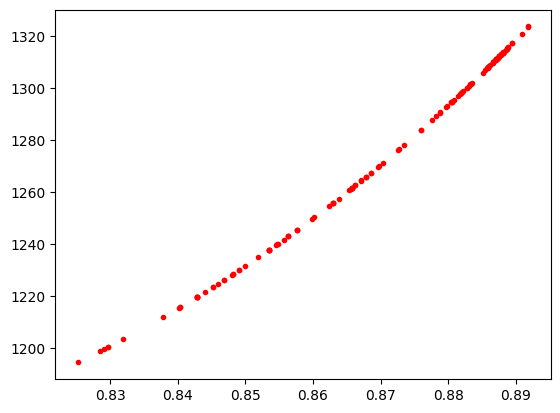

In [14]:
plt.plot(df_combo['Fo'], df_combo['Temp_from_Fo_all'], '.r')

## Lets propagate uncertainty

In [15]:
## Duan and Zhang Error propagate. 
MC_Av_rho_T_df_B, MC_All_rho_T_df_B, fig=pf.propagate_FI_uncertainty(
T_K=df_combo['Temp_from_Fo_all']+273.15,
error_T_K=df_combo['Temp_error'], error_type_T_K='Abs', error_dist_T_K='normal',
CO2_dens_gcm3=df_combo['Density g/cm3'],error_CO2_dens=df_combo['σ Density g/cm3'], 
error_type_CO2_dens='Abs', error_dist_CO2_dens='normal',
XH2O=XH2O_av, error_XH2O=pd.Series(0.5*np.abs(XH2O_max-XH2O_min)), error_type_XH2O='Abs', error_dist_XH2O='normal',
sample_ID=df_combo['filename'],
model='denlinger_lerner',
N_dup=500, fig_i=0, plot_figure=False)

You have entered a value for XH2O, so we are now using the EOS of Duan and Zhang 200 regardless of what model you selected. If you dont want this, specify XH2O=None
Please note, the DZ2006 EOS is about 5-40X slower to run than the SP94 and SW94 EOS
We are using multiprocessing based on your selected EOS. You can override this by setting multiprocess=False in the function, but it might slow it down a lot
Number of processors:  8


In [16]:

K24=df_combo['filename'].str.contains('K24')
U919=df_combo['filename'].str.contains('919')

In [17]:
df_combo['Fo']=df_combo['Fo'].fillna(0.9)

In [18]:
import Thermobar as pt

## Lets get the equilibrium Olivine Fo contents here 

In [19]:
Ulu_MG_input=pt.import_excel(r'C:\Users\charl\Documents\Python dev\2023_Kilauea-rapid-response-simulation\Kil_SWRZ\Kilauea2024_RapidResponseSWRZ_GDrive\Kilauea2024_RapidResponseSWRZ\1974_olivine_glass_data\UluData.xlsx',sheet_name='Matrix Glass')
Ulu_all=Ulu_MG_input['my_input'] ## All columns
Ulu_Liqs_all=Ulu_MG_input['Liqs'] ## Just Liquid columns
Ulu_Liqs_19=Ulu_Liqs_all.loc[Ulu_all['Eruption']==919]
Ulu_Liqs_19.head()
Mean_19=np.mean(Ulu_Liqs_19)

In [20]:
## Glasses 


K24_MG_input=pt.import_excel(r'GlassData2024.xlsx',
                         sheet_name='glass', suffix='_Liq')
K24_all=K24_MG_input['my_input'] ## All columns
K24_Liqs_all=K24_MG_input['Liqs'] ## Just Liquid columns
Liq_Mean_24=np.mean(K24_Liqs_all)

In [21]:
Eq_Ol_19=pt.calculate_eq_ol_content(liq_comps=Ulu_Liqs_19, Kd_model="Shea2022",Fe3Fet_Liq=0.18)
Eq_Ol_24=pt.calculate_eq_ol_content(liq_comps=K24_Liqs_all, Kd_model="Shea2022",Fe3Fet_Liq=0.18)

In [22]:
MC_Av_rho_T_df_B.to_excel("prop_depths.xlsx")

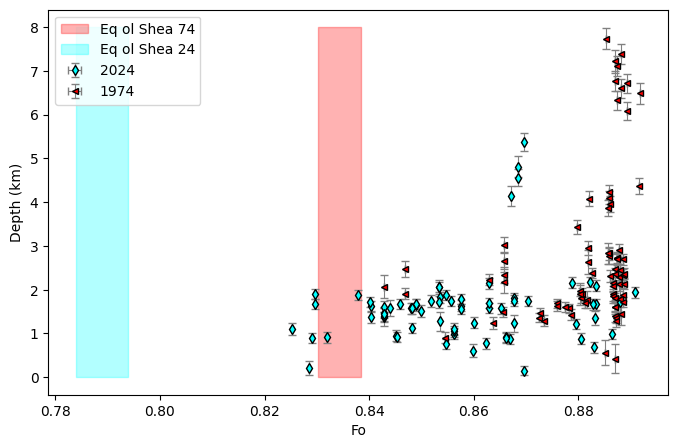

In [23]:
fig, (ax1) = plt.subplots(1, 1, figsize = (8,5))

# Calculate x coordinates
x1 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.345)'])

# Plot rectangle
plt.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='red', alpha=0.3, label='Eq ol Shea 74')

# Calculate x coordinates
x1 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.345)'])

# Plot rectangle
plt.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='cyan', alpha=0.3, label='Eq ol Shea 24')


ax1.errorbar(df_combo['Fo'].loc[K24], MC_Av_rho_T_df_B['SingleCalc_D_km'].loc[K24], xerr=0, yerr=MC_Av_rho_T_df_B['std_dev_MC_D_km_from_percentile'].loc[K24],
             fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', ms=5, mec='k', capsize=3, label='2024')
ax1.errorbar(df_combo['Fo'].loc[U919], MC_Av_rho_T_df_B['SingleCalc_D_km'].loc[U919], xerr=0, yerr=MC_Av_rho_T_df_B['std_dev_MC_D_km_from_percentile'].loc[U919],
             fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', ms=5, mec='k', capsize=3, label='1974')


ax1.set_xlabel('Fo')
ax1.set_ylabel('Depth (km)')
plt.legend()#
fig.savefig('FoDepth.png', dpi=300)

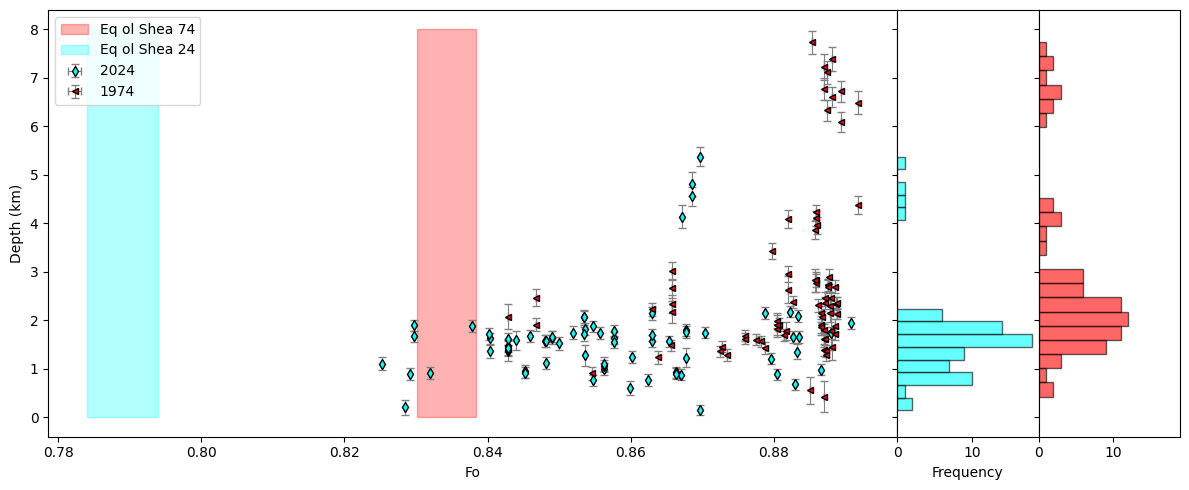

In [24]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 0.5, 0.5], wspace=0)

ax1 = plt.subplot(gs[0])

# Calculate x coordinates and plot rectangles for Eq_Ol_19
x1 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.345)'])
ax1.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='red', alpha=0.3, label='Eq ol Shea 74')

# Calculate x coordinates and plot rectangles for Eq_Ol_24
x1 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.345)'])
ax1.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='cyan', alpha=0.3, label='Eq ol Shea 24')

# Plot error bars
ax1.errorbar(df_combo['Fo'].loc[K24], MC_Av_rho_T_df_B['SingleCalc_D_km'].loc[K24], xerr=0, yerr=MC_Av_rho_T_df_B['std_dev_MC_D_km_from_percentile'].loc[K24],
             fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', ms=5, mec='k', capsize=3, label='2024')
ax1.errorbar(df_combo['Fo'].loc[U919], MC_Av_rho_T_df_B['SingleCalc_D_km'].loc[U919], xerr=0, yerr=MC_Av_rho_T_df_B['std_dev_MC_D_km_from_percentile'].loc[U919],
             fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', ms=5, mec='k', capsize=3, label='1974')

ax1.set_xlabel('Fo')
ax1.set_ylabel('Depth (km)')
ax1.legend()

# Histogram plot
ax2 = plt.subplot(gs[1], sharey=ax1)
ax3 = plt.subplot(gs[2], sharey=ax1, sharex=ax2)
ax2.hist(MC_Av_rho_T_df_B['SingleCalc_D_km'].loc[K24], bins=20, stacked=True, orientation='horizontal', color=['cyan'], ec='k', alpha=0.6)
ax3.hist(MC_Av_rho_T_df_B['SingleCalc_D_km'].loc[U919], bins=25, stacked=True, orientation='horizontal', color=['red'], ec='k', alpha=0.6)

ax2.set_xlabel('Frequency')
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.tight_layout()
fig.savefig('FoDepth.png', dpi=300)
plt.show()

In [27]:
# MC_Av_rho_T_df_B.to_clipboard(excel=True,index=False)
crystalnames=pd.read_excel(r"C:\Users\charl\Documents\Python dev\2023_Kilauea-rapid-response-simulation\Kil_SWRZ\Kilauea2024_RapidResponseSWRZ_GDrive\Kilauea2024_RapidResponseSWRZ\MCPD+Crystalnames.xlsx")
crystalnames

df_fullmerge=pd.merge(left=df_combo,left_on='filename',right=crystalnames,right_on='Filename',suffixes=('', '_correct'))
df_fullmerge.to_excel("Fully_merged.xlsx")

# Take a mean and standard dev for crystals

result = df_fullmerge.groupby('Crystal').agg({col: 'mean' if pd.api.types.is_numeric_dtype(col_type) else 'first' for col, col_type in df_fullmerge.dtypes.items()})
result_std = df_fullmerge.groupby('Crystal').agg({col: 'std' if pd.api.types.is_numeric_dtype(col_type) else 'first' for col, col_type in df_fullmerge.dtypes.items()})

K24=result['Crystal'].str.contains('K24')
U919=result['Crystal'].str.contains('919')

result

,Unnamed: 0.1,Unnamed: 0,Mount,filename,Name_on_SEM,Notes regarding SEM matching,Unnamed: 5,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),...,T_K_input_correct,error_T_K_correct,CO2_dens_gcm3_input_correct,error_CO2_dens_gcm3_correct,crust_dens_kgm3_input_correct,error_crust_dens_kgm3_correct,model_correct,EOS_correct,XH2O_input_correct,error_XH2O_correct
Crystal,,,,,,,,,,,,,,,,,,,,,
919_50,63.5,63.5,A,919_50_FIA,0919_50_FIA,None,919_50_FIA,0.146839,0.006837,0.005413,...,1586.067191,50.0,0.146839,0.006837,NaN,0.0,denlinger_lerner,DZ06,0.066676,0.036370
919_51,65.0,65.0,A,919_51_FIA,0919_51_FIA,None,919_51_FIA,0.191270,0.004434,0.003749,...,1585.870579,50.0,0.191270,0.004434,NaN,0.0,denlinger_lerner,DZ06,0.052970,0.029567
919_52,66.5,66.5,A,919_52_FIA,0919_52_FIA,None,919_52_FIA,0.148437,0.005006,0.003141,...,1582.395758,50.0,0.148437,0.005006,NaN,0.0,denlinger_lerner,DZ06,0.066089,0.036060
919_53,69.0,69.0,B,919_53_A,"919_53_FIA,B,C",None,919_53_A,0.179813,0.002678,0.001236,...,1585.324467,50.0,0.179813,0.002678,NaN,0.0,denlinger_lerner,DZ06,0.055259,0.030587
919_54,71.0,71.0,B,919_54_A,919_54_FIA,None,919_54_A,0.137740,0.004063,0.001254,...,1583.335491,50.0,0.137740,0.004063,NaN,0.0,denlinger_lerner,DZ06,0.071491,0.038940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KL0919-018,113.0,113.0,None,KL0919-018-A,KL0919_018_FIA,None,919_018_A,0.152686,0.004232,0.001624,...,1529.058450,50.0,0.152686,0.004232,NaN,0.0,denlinger_lerner,DZ06,0.066259,0.036142
KL0919-019,114.5,114.5,None,KL0919-019-A,KL0919_019_FIA+B,None,919_019_A,0.186159,0.010417,0.010075,...,1571.191035,50.0,0.186159,0.010417,NaN,0.0,denlinger_lerner,DZ06,0.054478,0.030264
KL0919-021,116.5,116.5,None,KL0919-021-A,KL0919_021_FIA,None,919_021_A,0.099029,0.004106,0.001537,...,1562.877260,50.0,0.099029,0.004106,NaN,0.0,denlinger_lerner,DZ06,0.103878,0.056903


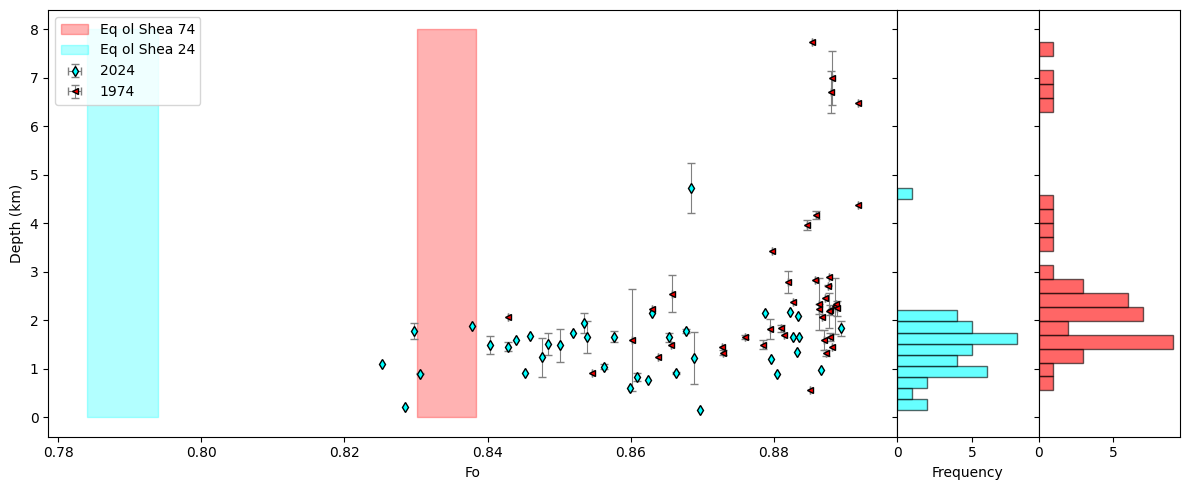

In [26]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 0.5, 0.5], wspace=0)

ax1 = plt.subplot(gs[0])

# Calculate x coordinates and plot rectangles for Eq_Ol_19
x1 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.345)'])
ax1.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='red', alpha=0.3, label='Eq ol Shea 74')

# Calculate x coordinates and plot rectangles for Eq_Ol_24
x1 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.345)'])
ax1.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='cyan', alpha=0.3, label='Eq ol Shea 24')

# Plot error bars
ax1.errorbar(result['Fo'].loc[K24], result['SingleCalc_D_km_correct'].loc[K24], xerr=0, yerr=result_std['SingleCalc_D_km_correct'].loc[K24],
             fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', ms=5, mec='k', capsize=3, label='2024')

ax1.errorbar(result['Fo'].loc[U919], result['SingleCalc_D_km_correct'].loc[U919], xerr=0, yerr=result_std['SingleCalc_D_km_correct'].loc[U919],
             fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', ms=5, mec='k', capsize=3, label='1974')

ax1.set_xlabel('Fo')
ax1.set_ylabel('Depth (km)')
ax1.legend()

# Histogram plot
ax2 = plt.subplot(gs[1], sharey=ax1)
ax3 = plt.subplot(gs[2], sharey=ax1, sharex=ax2)
ax2.hist(result['SingleCalc_D_km_correct'].loc[K24], bins=20, stacked=True, orientation='horizontal', color=['cyan'], ec='k', alpha=0.6)
ax3.hist(result['SingleCalc_D_km_correct'].loc[U919], bins=25, stacked=True, orientation='horizontal', color=['red'], ec='k', alpha=0.6)

ax2.set_xlabel('Frequency')
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.tight_layout()
fig.savefig('FoDepth_averagecrystal.png', dpi=300)
plt.show()